In [226]:
from sklearn.datasets import fetch_openml
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import time
from keras.datasets import fashion_mnist
import keras
import matplotlib.pyplot as plt


In [227]:
!pip install wandb
import wandb

In [228]:
wandb.login()

True

In [229]:
sweep_config = {
    'method': 'grid', #grid, random
    'metric': {
      'name': 'acc',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [5, 10]
        },
        'batch_size': {
            'values': [16, 32 ,64]
        },
        
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        
        'optimizer': {
            'values': ['sgd']
        },
    }
}

In [230]:
sweep_id = wandb.sweep(sweep_config, project="Assignment_1")

Create sweep with ID: vswekhnx
Sweep URL: https://wandb.ai/cs21m073/Assignment_1/sweeps/vswekhnx


In [231]:

dataset = keras.datasets.fashion_mnist
(train_inputs, train_outputs), (test_inputs, tes_outputs) = dataset.load_data()

train_inputs, val_inputs, train_outputs, val_outputs = train_test_split(train_inputs, train_outputs, test_size=0.15, random_state=24)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


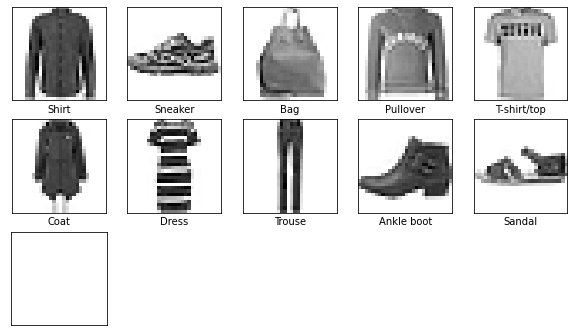

In [232]:
## Printing one image from each class
labels = ['T-shirt/top', 'Trouse', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10, 10))
flag = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
j=0
for i in range(130):
  plt.subplot(5, 5, j+1)
  plt.xticks([])
  plt.yticks([])
  if(flag[train_outputs[i]] == 0):
    plt.imshow(train_inputs[i], cmap=plt.cm.binary)
    plt.xlabel(labels[train_outputs[i]])
    flag[train_outputs[i]] = 1
    j = j+1

In [233]:

train_inputs = (train_inputs/255).astype('float32')
train_outputs = to_categorical(train_outputs)

val_inputs = (val_inputs/255).astype('float32')
val_outputs = to_categorical(val_outputs)

test_inputs = (test_inputs/255).astype('float32')
test_outputs = to_categorical(tes_outputs)


In [234]:
class FeedforwardNN():
    def __init__(self, sizes, layers, epochs, l_rate):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.layers = layers
        # we save all parameters in the neural network in this dictionary
        (self.weights, self.bias) = self.initialization()
        self.a_values = dict()
        self.h_values = dict()

    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    def dsigmoid(self, x):
      return (np.exp(-x))/((np.exp(-x)+1)**2)
    
    def ReLU(self, x):
      return np.maximum(0,x)

    def dReLU(self,x):
      return 1 * (x > 0) 

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):     
        weight = dict()
        bias = dict()
        for itr in range(1, self.layers):
           weight[itr] = np.random.randn(self.sizes[itr], self.sizes[itr-1]) * np.sqrt(1. / self.sizes[itr])
           bias[itr] = np.random.randn(self.sizes[itr], 1) * np.sqrt(1. / self.sizes[itr])
        return (weight, bias)


    def forward(self, x_train):

        # input layer activations becomes sample
        self.h_values[0] = x_train.reshape(-1)
        
        for itr in range(1, self.layers):
           self.a_values[itr] = np.add(np.dot(self.weights[itr], self.h_values[itr-1]), self.bias[itr].reshape(-1))
           if(itr == self.layers-1):
             self.h_values[itr] = self.softmax(self.a_values[itr])
           else:
             self.h_values[itr] = self.sigmoid(self.a_values[itr])

        return self.h_values[self.layers-1]

    def backward(self, y_train, output):
        delta_weight = dict()
        delta_bias = dict()

        #der_wrt_L = 2 * (output - y_train) / output.shape[0] * self.softmax(self.a_values[self.layers-1], derivative=True)
        der_wrt_L = -(y_train-output) * self.softmax(self.a_values[self.layers-1], derivative=True)
        for itr in range(self.layers-1, 0, -1):
          delta_weight[itr] = np.outer(der_wrt_L, self.h_values[itr-1])
          delta_bias[itr] = der_wrt_L
          if(itr > 1):
            der_wrt_prev_k = np.dot(self.weights[itr].T, der_wrt_L)
            der_wrt_L = der_wrt_prev_k * self.dsigmoid(self.a_values[itr-1])

        return (delta_weight, delta_bias)

    def update_parameters(self, changes_to_w, changes_to_b):        
        for key, value in changes_to_w.items():
            self.weights[key] -= self.l_rate * value
        
        for itr in range(1, self.layers):
          self.bias[itr] = np.subtract(self.bias[itr].reshape(-1) ,np.multiply(self.l_rate, changes_to_b[itr]))


    def compute_accuracy(self, x_val, y_val):
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)

    def train(self, x_train, y_train, x_val, y_val):
          default_config={
          "learning_rate": self.l_rate,
          "epochs": self.epochs,
          "batch_size": 20,
          "optimizer":'sgd'
          }
          wandb.init(
          # Set the project where this run will be logged
          project="Assignment_1", 
          # Track hyperparameters and run metadata
          config=default_config)
          config = wandb.config
          start_time = time.time()        
          print("Training using mini batch Gradient Descent")
          
          j = 1
          delta_w = dict()
          delta_b = dict()
          temp = 0
          for iteration in range(config.epochs):
            j = 1
            for x, y in zip(x_train, y_train):
              y_hat = self.forward(x)
              (dw, db) = self.backward(y, y_hat)
              if(j == 1):
                  delta_w = dw
                  delta_b = db
                  j = j+1
              else:
                for itr in range(1, self.layers):
                  delta_w[itr] = np.add(delta_w[itr], dw[itr])
                  delta_b[itr] = np.add(delta_b[itr], db[itr])

              temp = temp + 1
              if(temp % config.batch_size == 0):
                self.update_parameters(delta_w,delta_b)
                delta_w = dict()
                delta_b = dict()
                temp = 0
                j = 1
            accuracy = self.compute_accuracy(x_val, y_val)     
            wandb.log({"acc": accuracy})       
            print('Epoch: {0}, Time Spent: {1:.2f}s, Val Accuracy: {2:.2f}%'.format(
                  iteration+1, time.time() - start_time, accuracy * 100
              ))
          wandb.finish()
           
            
            


In [235]:

def train():
  noOfLayers = 4
  sizes = [784, 128, 64, 10]
  learning_rate = 0.01
  epochs = 5
  batch_size = 20


  fnn = FeedforwardNN(sizes, noOfLayers, epochs, learning_rate)
  fnn.train(train_inputs, train_outputs, val_inputs, val_outputs)

wandb.agent(sweep_id, train)

wandb: Agent Starting Run: osvl421y with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Training using mini batch Gradient Descent
Epoch: 1, Time Spent: 25.70s, Val Accuracy: 69.87%
Epoch: 2, Time Spent: 51.14s, Val Accuracy: 79.72%
Epoch: 3, Time Spent: 76.85s, Val Accuracy: 81.51%
Epoch: 4, Time Spent: 102.54s, Val Accuracy: 82.26%
Epoch: 5, Time Spent: 127.99s, Val Accuracy: 83.24%


acc,▁▆▇▇█
acc,0.83244


wandb: Agent Starting Run: c6vpuug9 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Training using mini batch Gradient Descent
Epoch: 1, Time Spent: 25.83s, Val Accuracy: 67.90%
Epoch: 2, Time Spent: 51.56s, Val Accuracy: 77.51%
Epoch: 3, Time Spent: 77.30s, Val Accuracy: 79.08%
Epoch: 4, Time Spent: 102.91s, Val Accuracy: 80.57%
Epoch: 5, Time Spent: 128.66s, Val Accuracy: 81.32%


acc,▁▆▇██
acc,0.81322


wandb: Agent Starting Run: 8pjmatf2 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Training using mini batch Gradient Descent
Epoch: 1, Time Spent: 25.67s, Val Accuracy: 65.99%
Epoch: 2, Time Spent: 51.22s, Val Accuracy: 72.39%
Epoch: 3, Time Spent: 76.84s, Val Accuracy: 77.29%
Epoch: 4, Time Spent: 102.43s, Val Accuracy: 78.58%
Epoch: 5, Time Spent: 128.04s, Val Accuracy: 80.06%
Epoch: 6, Time Spent: 153.59s, Val Accuracy: 81.13%
Epoch: 7, Time Spent: 179.21s, Val Accuracy: 82.34%
Epoch: 8, Time Spent: 205.07s, Val Accuracy: 82.92%
Epoch: 9, Time Spent: 230.60s, Val Accuracy: 83.86%
Epoch: 10, Time Spent: 256.13s, Val Accuracy: 84.07%


acc,▁▃▅▆▆▇▇███
acc,0.84067


wandb: Agent Starting Run: qosbosfa with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Training using mini batch Gradient Descent
Epoch: 1, Time Spent: 25.65s, Val Accuracy: 69.78%
Epoch: 2, Time Spent: 51.27s, Val Accuracy: 79.37%
Epoch: 3, Time Spent: 76.93s, Val Accuracy: 81.03%
Epoch: 4, Time Spent: 102.57s, Val Accuracy: 82.34%
Epoch: 5, Time Spent: 128.54s, Val Accuracy: 83.09%
Epoch: 6, Time Spent: 154.25s, Val Accuracy: 83.60%
Epoch: 7, Time Spent: 180.30s, Val Accuracy: 84.10%
Epoch: 8, Time Spent: 206.21s, Val Accuracy: 84.56%
Epoch: 9, Time Spent: 232.46s, Val Accuracy: 84.54%
Epoch: 10, Time Spent: 258.47s, Val Accuracy: 84.56%


acc,▁▆▆▇▇█████
acc,0.84556


wandb: Agent Starting Run: afklkff2 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Training using mini batch Gradient Descent
Epoch: 1, Time Spent: 25.54s, Val Accuracy: 72.47%
Epoch: 2, Time Spent: 51.09s, Val Accuracy: 79.98%
Epoch: 3, Time Spent: 76.55s, Val Accuracy: 81.18%
Epoch: 4, Time Spent: 102.04s, Val Accuracy: 81.97%
Epoch: 5, Time Spent: 127.45s, Val Accuracy: 83.33%


acc,▁▆▇▇█
acc,0.83333


wandb: Agent Starting Run: l6epwpwy with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Training using mini batch Gradient Descent
Epoch: 1, Time Spent: 25.44s, Val Accuracy: 74.52%
Epoch: 2, Time Spent: 50.92s, Val Accuracy: 78.02%
Epoch: 3, Time Spent: 76.47s, Val Accuracy: 81.17%
Epoch: 4, Time Spent: 102.19s, Val Accuracy: 78.88%
Epoch: 5, Time Spent: 127.89s, Val Accuracy: 82.42%


acc,▁▄▇▅█
acc,0.82422


wandb: Agent Starting Run: 7zrykft6 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Training using mini batch Gradient Descent
Epoch: 1, Time Spent: 25.71s, Val Accuracy: 73.50%
Epoch: 2, Time Spent: 51.42s, Val Accuracy: 76.91%
Epoch: 3, Time Spent: 76.92s, Val Accuracy: 77.40%
Epoch: 4, Time Spent: 102.35s, Val Accuracy: 78.61%
Epoch: 5, Time Spent: 127.87s, Val Accuracy: 81.76%
Epoch: 6, Time Spent: 153.27s, Val Accuracy: 82.48%
Epoch: 7, Time Spent: 178.94s, Val Accuracy: 81.98%
Epoch: 8, Time Spent: 204.58s, Val Accuracy: 81.94%
Epoch: 9, Time Spent: 230.14s, Val Accuracy: 83.49%
Epoch: 10, Time Spent: 255.95s, Val Accuracy: 83.80%


acc,▁▃▄▄▇▇▇▇██
acc,0.838


wandb: Agent Starting Run: i6zrfhot with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Training using mini batch Gradient Descent
Epoch: 1, Time Spent: 25.80s, Val Accuracy: 75.77%
Epoch: 2, Time Spent: 51.47s, Val Accuracy: 80.49%
Epoch: 3, Time Spent: 77.10s, Val Accuracy: 79.14%
Epoch: 4, Time Spent: 102.55s, Val Accuracy: 78.66%
Epoch: 5, Time Spent: 128.12s, Val Accuracy: 81.62%
Epoch: 6, Time Spent: 153.64s, Val Accuracy: 83.00%
Epoch: 7, Time Spent: 179.16s, Val Accuracy: 81.64%
Epoch: 8, Time Spent: 205.06s, Val Accuracy: 83.78%
Epoch: 9, Time Spent: 230.75s, Val Accuracy: 84.28%
Epoch: 10, Time Spent: 256.72s, Val Accuracy: 84.77%


acc,▁▅▄▃▆▇▆▇██
acc,0.84767


wandb: Agent Starting Run: uvox6383 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Training using mini batch Gradient Descent
Epoch: 1, Time Spent: 25.46s, Val Accuracy: 75.17%
Epoch: 2, Time Spent: 50.95s, Val Accuracy: 79.62%
Epoch: 3, Time Spent: 76.65s, Val Accuracy: 81.12%
Epoch: 4, Time Spent: 102.30s, Val Accuracy: 81.73%
Epoch: 5, Time Spent: 127.83s, Val Accuracy: 82.41%


acc,▁▅▇▇█
acc,0.82411


wandb: Agent Starting Run: cws0uu4m with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Training using mini batch Gradient Descent
Epoch: 1, Time Spent: 25.41s, Val Accuracy: 75.94%
Epoch: 2, Time Spent: 50.66s, Val Accuracy: 79.72%
Epoch: 3, Time Spent: 76.17s, Val Accuracy: 79.82%
Epoch: 4, Time Spent: 101.62s, Val Accuracy: 80.82%
Epoch: 5, Time Spent: 127.32s, Val Accuracy: 81.20%


acc,▁▆▆▇█
acc,0.812


wandb: Agent Starting Run: xyp4y3kg with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Training using mini batch Gradient Descent
Epoch: 1, Time Spent: 25.46s, Val Accuracy: 75.32%
Epoch: 2, Time Spent: 50.87s, Val Accuracy: 79.83%
Epoch: 3, Time Spent: 76.20s, Val Accuracy: 80.66%
Epoch: 4, Time Spent: 101.51s, Val Accuracy: 81.44%
Epoch: 5, Time Spent: 126.97s, Val Accuracy: 82.31%
Epoch: 6, Time Spent: 152.27s, Val Accuracy: 83.37%
Epoch: 7, Time Spent: 177.96s, Val Accuracy: 83.83%
Epoch: 8, Time Spent: 203.36s, Val Accuracy: 84.18%
Epoch: 9, Time Spent: 229.14s, Val Accuracy: 83.76%
Epoch: 10, Time Spent: 254.93s, Val Accuracy: 83.34%


acc,▁▅▅▆▇▇███▇
acc,0.83344


wandb: Agent Starting Run: 0as3nev7 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Training using mini batch Gradient Descent
Epoch: 1, Time Spent: 25.70s, Val Accuracy: 69.12%
Epoch: 2, Time Spent: 51.38s, Val Accuracy: 74.46%
Epoch: 3, Time Spent: 77.34s, Val Accuracy: 77.93%
Epoch: 4, Time Spent: 103.16s, Val Accuracy: 79.18%
Epoch: 5, Time Spent: 128.89s, Val Accuracy: 80.32%
Epoch: 6, Time Spent: 154.66s, Val Accuracy: 81.44%
Epoch: 7, Time Spent: 180.47s, Val Accuracy: 81.88%
Epoch: 8, Time Spent: 206.14s, Val Accuracy: 82.18%
Epoch: 9, Time Spent: 231.84s, Val Accuracy: 82.81%
Epoch: 10, Time Spent: 257.32s, Val Accuracy: 82.32%


acc,▁▄▆▆▇▇████
acc,0.82322


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
